# Wasserstein And Bottleneck

In this module, we will explore the Wasserstein and Bottleneck distance between persistence diagrams, and we will empirically explore their stability.

First, we do all of the necessary imports


In [1]:
#Do all of the imports and setup inline plotting
import time
import numpy as np
from scipy import sparse
#from ripser import ripser
#from ripser import plot_dgms
import ripser
import cechmate as cm
from persim import plot_diagrams
from persim import wasserstein, wasserstein_matching
from persim import bottleneck, bottleneck_matching
import persim
#import persim.plot
import networkx as nx
from networkx import bipartite
import gudhi
from gudhi import hera
from igraph import *
#import gurobipy as gp
#from gurobipy import GRB
#from hopcroftkarp import HopcroftKarp

%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [21]:
def prokhorov(I1, I2, matching=False):
    g = nx.Graph()
    #add nodes for points
    g.add_nodes_from(list(zip(range(0,len(I1)),[0]*len(I1))), bipartite=0)
    g.add_nodes_from(list(zip(range(0,len(I2)),[1]*len(I2))), bipartite=1)
    #add all edges with cost = max.norm
    for v in [n for n, d in g.nodes(data=True) if d['bipartite']==0]:
        for w in [n for n, d in g.nodes(data=True) if d['bipartite']==1]:
            cost = max(abs(I1[v[0],0]-I2[w[0],0]),abs(I1[v[0],1]-I2[w[0],1]))#/2#*(1-I1[v[0],1]+I1[v[0],0])*(1-I2[w[0],1]+I2[w[0],0])
            #print(cost)
            g.add_edge(v,w, weight=cost)#nudge towards matching off-diagonal points?

    #add points on the diagonal
    g.add_nodes_from(list(zip(range(len(I1),len(I1)+len(I2)),[0]*len(I2))), bipartite=0)
    g.add_nodes_from(list(zip(range(len(I2),len(I2)+len(I1)),[1]*len(I1))), bipartite=1)
    #add edges to the diagonal with cost = max.norm
    for v in range(0,len(I1)):
        cost = (I1[v,1]-I1[v,0])/2
        g.add_edge((v,0),(len(I2)+v,1), weight=cost)
    for v in range(0,len(I2)):
        cost = (I2[v,1]-I2[v,0])/2
        g.add_edge((v,1),(len(I1)+v,0), weight=cost)
    for w in range(0,len(I1)):
        for v in range(0,len(I2)):
            g.add_edge((len(I1)+v,0), (len(I2)+w,1),weight = 0)

    #Get weights and sort them
    weights = nx.get_edge_attributes(g, "weight")
    #sorted_weights = np.sort(np.fromiter(weights.values(),dtype=float))

    #perform binary search
    L=0
    R=max(weights.values())#len(sorted_weights)-1
    print(max(weights.values()))
    eps = 0
    match = None
    while(R-L>0.00001):
        #m = 
        old_eps=eps
        eps = (L+R)/2
        geps=nx.create_empty_copy(g)
        for v in [n for n, d in g.nodes(data=True) if d['bipartite']==0]:
            for w in [n for n, d in g.nodes(data=True) if d['bipartite']==1]:
                if (v,w) in g.edges():
                    if (v,w) in weights:
                        if weights[(v,w)]<=eps:
                            geps.add_edge(v,w)
                    else:
                        if weights[(w,v)]<=eps:
                            geps.add_edge(v,w)
        #Compute matching on subgraph geps
        old_match = match
        match = nx.bipartite.hopcroft_karp_matching(geps,[n for n, d in g.nodes(data=True) if d['bipartite']==0])
        #Compute the amount of unmatched points
        match = [(x[0],y[0]) for x,y in match.items() if x[1]==0]
        number_of_unmatched_points = len(I1)+len(I2)-len(match)
        
        #print("for t = {} the matching has size {}".format(eps, len(match)))
        
        if number_of_unmatched_points > eps:
            L = eps
        elif number_of_unmatched_points < eps:
            R = eps
        
        #if R-L <=1:
         #   if R==L:
          #      break
           # else:
            #    if number_of_unmatched_points > eps:
             #       L=R
              #  elif number_of_unmatched_points < eps:
               #     R=L
        #else:
         #   if number_of_unmatched_points > eps:
          #      L = m
           # elif number_of_unmatched_points < eps:
            #    R = m
            #else:
             #   break
    
    dist = old_eps#min(amount, sorted_weights[m+1]) if m > 0 else eps
    
    if matching:
        return dist, old_match
    else:
        return dist

In [10]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [11]:
def prokhorov_series(I1, I2):
    g = nx.Graph()
    #add nodes for points
    g.add_nodes_from(list(zip(range(0,len(I1)),[0]*len(I1))), bipartite=0)
    g.add_nodes_from(list(zip(range(0,len(I2)),[1]*len(I2))), bipartite=1)
    #add all edges with cost = max.norm
    for v in [n for n, d in g.nodes(data=True) if d['bipartite']==0]:
        for w in [n for n, d in g.nodes(data=True) if d['bipartite']==1]:
            cost = max(abs(I1[v[0],0]-I2[w[0],0]),abs(I1[v[0],1]-I2[w[0],1]))#/2#*(1-I1[v[0],1]+I1[v[0],0])*(1-I2[w[0],1]+I2[w[0],0])
            #print(cost)
            g.add_edge(v,w, weight=cost)#nudge towards matching off-diagonal points?

    #add points on the diagonal
    g.add_nodes_from(list(zip(range(len(I1),len(I1)+len(I2)),[0]*len(I2))), bipartite=0)
    g.add_nodes_from(list(zip(range(len(I2),len(I2)+len(I1)),[1]*len(I1))), bipartite=1)
    #add edges to the diagonal with cost = max.norm
    for v in range(0,len(I1)):
        cost = (I1[v,1]-I1[v,0])/2
        g.add_edge((v,0),(len(I2)+v,1), weight=cost)
    for v in range(0,len(I2)):
        cost = (I2[v,1]-I2[v,0])/2
        g.add_edge((v,1),(len(I1)+v,0), weight=cost)
    for w in range(0,len(I1)):
        for v in range(0,len(I2)):
            g.add_edge((len(I1)+v,0), (len(I2)+w,1),weight = 0)

    #Get weights and sort them
    weights = nx.get_edge_attributes(g, "weight")
    sorted_weights = np.sort(np.fromiter(weights.values(),dtype=float))
    sorted_weights=sorted_weights[sorted_weights!=0]
    unmatched_series = np.zeros((len(sorted_weights),2))
    index = 0
   
    for eps in sorted_weights:
        geps=nx.create_empty_copy(g)
        for v in [n for n, d in g.nodes(data=True) if d['bipartite']==0]:
            for w in [n for n, d in g.nodes(data=True) if d['bipartite']==1]:
                if (v,w) in g.edges():
                    if (v,w) in weights:
                        if weights[(v,w)]<=eps:
                            geps.add_edge(v,w)
                    else:
                        if weights[(w,v)]<=eps:
                            geps.add_edge(v,w)
        #Compute matching on subgraph geps
        match = nx.bipartite.hopcroft_karp_matching(geps,[n for n, d in g.nodes(data=True) if d['bipartite']==0])
        #Compute the amount of unmatched points
        match = [(x[0],y[0]) for x,y in match.items() if x[1]==0]
        number_of_unmatched_points = len(I1)+len(I2)-len(match)
        
        unmatched_series [index,:]=(eps, number_of_unmatched_points)
        index = index +1
    
    return(unmatched_series)
    

## Example 1: Noisy Circle Matching

Let's first do a simple example of matching the H1 persistence diagram for points sampled from a circle to the H1 diagram from a noisy version of that circle.  We'll use the alpha filtration to get our persistence diagrams since we are in such a low dimension.

#### Questions
* What happens when you increase the noise?  Is there an amount of noise where the bottleneck point gets matched to a different point than the same point in the Wasserstein matching?

In [58]:
# First, sample points from a circle
np.random.seed(0)
# First point cloud has no noise
N1 = 100
X1 = np.zeros((N1, 2))
t1 = np.linspace(0, 2*np.pi, N1+1)[0:N1]
X1[:, 0] = 1*np.cos(t1)-2
X1[:, 1] = 1*np.sin(t1)
X1 = X1 + 0.07*np.random.randn(N1, 2)

# Second point cloud has a lot of noisy points
N2 = 100
t2 = np.linspace(0, 2*np.pi, N2+1)[0:N2]
X2 = np.zeros((N2, 2))
X2[:, 0] = np.cos(t2)+2
X2[:, 1] = np.sin(t2)
X2 = X2 + 0.07*np.random.randn(N2, 2)

N3 = 100
t3 = np.linspace(0, 2*np.pi, N3+1)[0:N3]
X3 = np.zeros((N3, 2))
X3[:, 0] = np.cos(t3)-2
X3[:, 1] = np.sin(t3)
X3 = X3 + 0.07*np.random.randn(N3, 2)

X2=np.append(X2,X3,axis=0)
X1=X1*100
X2=X2*100

alpha = cm.Alpha()
filtration = alpha.build(X1)
I1 = alpha.diagrams(filtration)[1]
filtration = alpha.build(X2)
I2 = alpha.diagrams(filtration)[1]

# Perform the matchings
tic = time.time()
bdist, (matchidxb, bD) = bottleneck(I1, I2, matching=True)
wdist, (matchidxw, wD) = wasserstein(I1, I2, matching=True)
pdist, matchidxp = prokhorov(I1,I2, matching = True)
for p in range(1,11):
    W_p = gudhi.hera.wasserstein_distance(I1, I2, order = p, internal_p = float("inf"))
    print("Wasserstein-{}-distance: {}; d_p <= {}".format(p, W_p, W_p**(p/(p+1))))
print("Elapsed Time Matching: %.3g"%(time.time()-tic))
unmatched_series = fast_prokhorov_series(I1,I2)
#unmatched_series2 = prokhorov_series(I1,I2)

Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 0.002)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 0.0541)
Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.00699)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.00201)
Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 0.001)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 0.104)
Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.019)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.003)
94.20116638804228
Wasserstein-1-distance: 49.6640788093031; d_p <= 7.047274566050559
Wasserstein-2-distance: 36.94323897343604; d_p <= 11.09234357119604
Wasserstein-3-distance: 36.87709075676908; d_p <= 14.964681882669051
Wasserstein-4-distance: 36.87437786177195

<IPython.core.display.Javascript object>


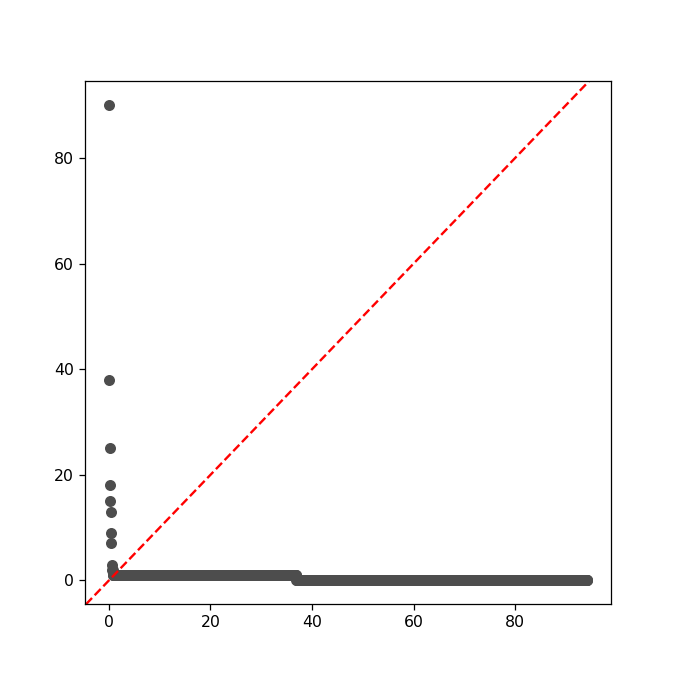

<IPython.core.display.Javascript object>


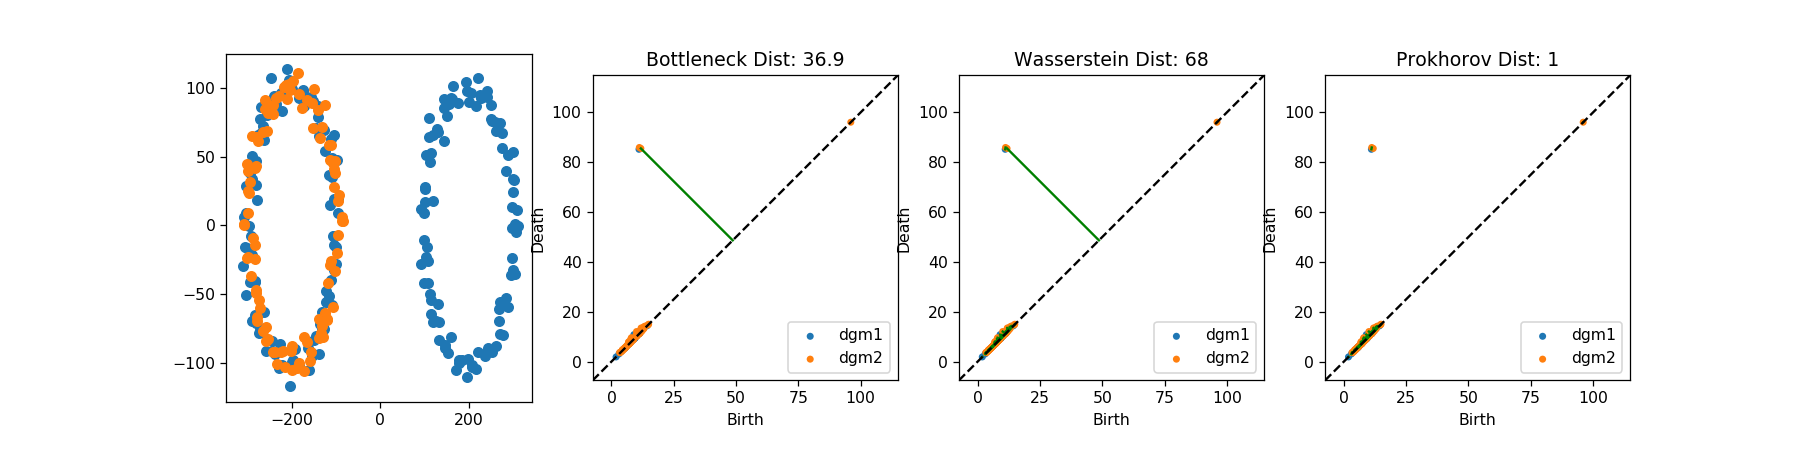

In [59]:
diam = np.max([[max(abs(x[0]-y[0]), abs(x[1]-y[1]))for x in I1] for y in I2])


f, ax = plt.subplots(figsize=(6, 6))
#plt.subplot(121)
ax.scatter(unmatched_series[:, 0], unmatched_series[:, 1], c=".3")
add_identity(ax, color='r', ls='--')
#x = np.linspace(0, 100, 200) 
#for p in range(1,11):
 #   W_p = gudhi.hera.wasserstein_distance(I1, I2, order = p, internal_p = float("inf"))
  #  h1 = plt.plot(x, (W_p**p)/(x**p), lw=2)
   # h2 = plt.plot(x, (((W_p**p)-x*(len(I1)+len(I2)))/(diam**p-x))**p, lw=2)
#plt.subplot(122)

#f, ax = plt.subplots(figsize=(6, 6))
#ax.scatter(unmatched_series2[:, 0], unmatched_series2[:, 1], c=".3")
#add_identity(ax, color='r', ls='--')
#plt.show()

plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.scatter(X2[:, 0], X2[:, 1])
plt.scatter(X1[:, 0], X1[:, 1])
plt.subplot(142)
bottleneck_matching(I1, I2, matchidxb, bD)
plt.title("Bottleneck Dist: %.3g"%bdist)
plt.subplot(143)
wasserstein_matching(I1, I2, matchidxw)
plt.title("Wasserstein Dist: %.3g"%wdist)
plt.subplot(144)
wasserstein_matching(I1,I2,matchidxp)
plt.title("Prokhorov Dist: %.3g"%pdist)
plt.show()

In [55]:
fast_prokhorov(I1,I2)

L = 0, R = 7047, mid = 3523
for t = 5.6072465776307485 the matching has size 163
L = 0, R = 3523, mid = 1761
for t = 2.7274087561015303 the matching has size 162
L = 0, R = 1761, mid = 880
for t = 1.4335609609749582 the matching has size 160
L = 880, R = 1761, mid = 1320
for t = 2.0410650097057186 the matching has size 161
L = 1320, R = 1761, mid = 1540
for t = 2.3992779341424164 the matching has size 162
L = 1320, R = 1540, mid = 1430
for t = 2.2187861350976057 the matching has size 161
L = 1430, R = 1540, mid = 1485
for t = 2.3034611539360146 the matching has size 162
L = 1430, R = 1485, mid = 1457
for t = 2.250088535953945 the matching has size 162
L = 1430, R = 1457, mid = 1443
for t = 2.2338688027291287 the matching has size 161
L = 1443, R = 1457, mid = 1450
for t = 2.2431169872619385 the matching has size 161
L = 1450, R = 1457, mid = 1453
for t = 2.2486153786133976 the matching has size 161
L = 1453, R = 1457, mid = 1455
for t = 2.249029506358438 the matching has size 161
L = 1

2.2490958913443038

In [7]:
x_range = np.linspace(100001,100100,100)
p_range = np.linspace(100001,100100,100)
b_range = np.linspace(100001,100100,100)

for i in range(1,len(x_range)):
    J1=I1*x_range[i]
    J2=I2*x_range[i]
    pdist = prokhorov(J1,J2)
    print(x_range[i],", ",pdist)
    p_range[i] = pdist
    b_range[i] = bottleneck(J1,J2)

100002.0 ,  85.14542266557692
100003.0 ,  85.14627410273533
100004.0 ,  85.14712553995196
100005.0 ,  85.14797697716858
100006.0 ,  85.148828414327
100007.0 ,  85.14967985154362
100008.0 ,  85.15053128876025
100009.0 ,  85.15138272591867
100010.0 ,  85.15223416313529
100011.0 ,  85.1530856002937
100012.0 ,  85.15393703751033
100013.0 ,  85.15478847472696
100014.0 ,  85.15563991188537
100015.0 ,  85.156491349102
100016.0 ,  85.15734278631862
100017.0 ,  85.15819422347704
100018.0 ,  85.15904566069366
100019.0 ,  85.1598970979685
100020.0 ,  85.16074853512691
100021.0 ,  85.16159997234354
100022.0 ,  85.16245140956016
100023.0 ,  85.16330284671858
100024.0 ,  85.1641542839352
100025.0 ,  85.16500572109362
100026.0 ,  85.16585715831025
100027.0 ,  85.16670859552687
100028.0 ,  85.16756003268529
100029.0 ,  85.16841146990191
100030.0 ,  85.16926290711854
100031.0 ,  85.17011434427695
100032.0 ,  85.17096578149358
100033.0 ,  85.1718172187102
100034.0 ,  85.17266865586862
100035.0 ,  85.173

<IPython.core.display.Javascript object>


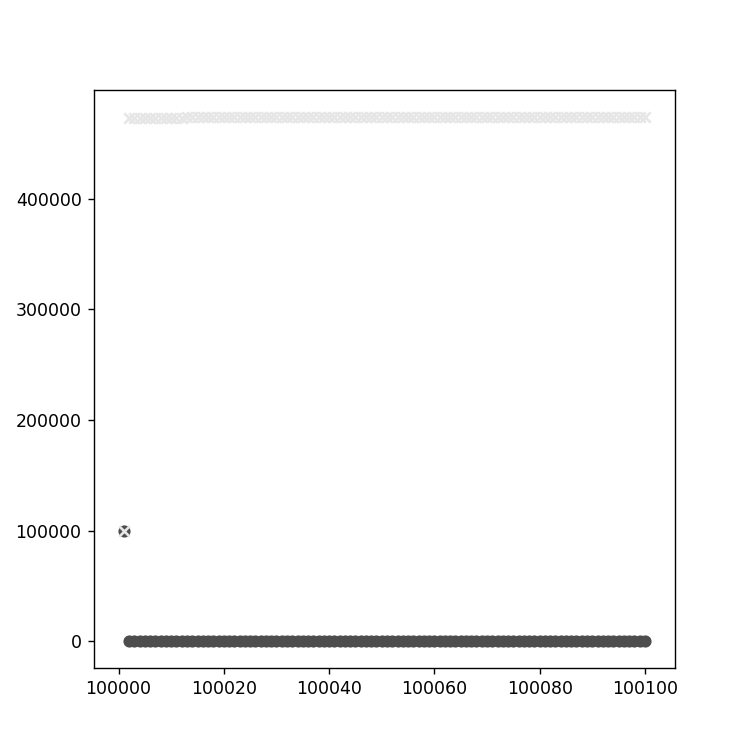

In [8]:

f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_range, p_range, c=".3", marker = 'o')
ax.scatter(x_range, b_range, c=".9", marker = 'x')

<IPython.core.display.Javascript object>


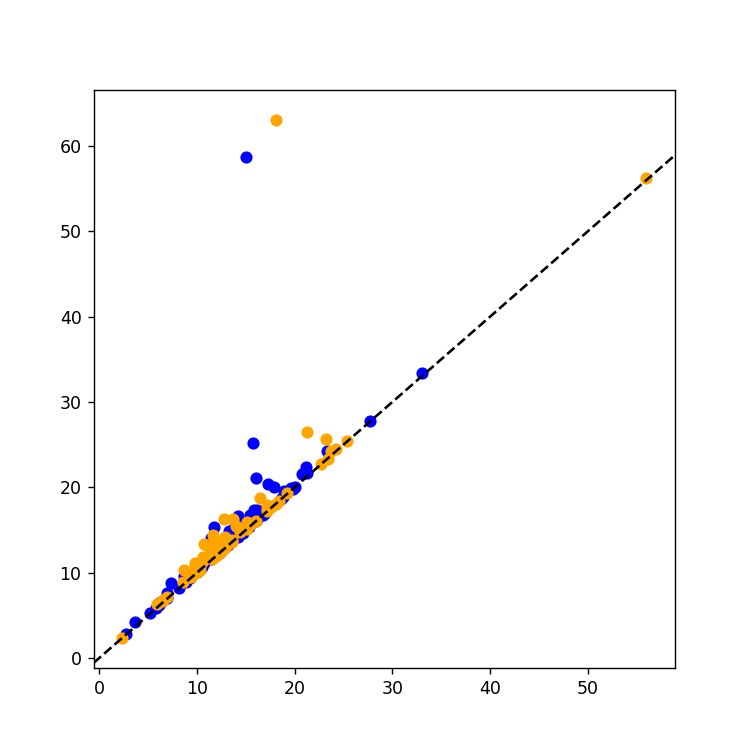

In [9]:
f, ax = plt.subplots(figsize=(6, 6))
add_identity(ax, color='k', ls='--')
ax.scatter(I1[:, 0], I1[:, 1], c="blue")
ax.scatter(I2[:, 0], I2[:, 1], c="orange")


## Example 2: Stability of Noisy Sublevelset Filtration

We will now explore a different example of a <i>sublevelset filtration</i> or a ''lower star filtration'' of a 1D time series, compared to the lower star filtration of a time series with some noise added.

First, we define a sparse distance matrix which represents the lower star filtration


In [2]:
def getLowerStarTimeSeriesD(x):
    N = x.size
    # Add edges between adjacent points in the time series, with the "distance" 
    # along the edge equal to the max value of the points it connects
    I = np.arange(N-1)
    J = np.arange(1, N)
    V = np.maximum(x[0:-1], x[1::])
    # Add vertex birth times along the diagonal of the distance matrix
    I = np.concatenate((I, np.arange(N)))
    J = np.concatenate((J, np.arange(N)))
    V = np.concatenate((V, x))
    #Create the sparse distance matrix
    D = sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()
    return D

Now, we can perfor sublevelset filtrations on a time series by itself and with a small amount of noise added

#### Exercise / Question

* In the example below, increase the number of samples, while keeping the standard deviation of the noise fixed.  Does one of the distances seem more stable than the other?  Can you explain in this instance why?

In [41]:
np.random.seed(0)
NSamples = 500
t = np.linspace(0, 50, NSamples)
x = 10*(np.cos(0.2*np.pi*t) + 0.1*t)
y = x + 2*np.random.randn(NSamples)

Dx = getLowerStarTimeSeriesD(x)
Dy = getLowerStarTimeSeriesD(y)
Ix = ripser.ripser(Dx, distance_matrix=True, maxdim=0)['dgms'][0]
Iy = ripser.ripser(Dy, distance_matrix=True, maxdim=0)['dgms'][0]




#Remove point at infinity before bottleneck/wasserstein
Ix = Ix[np.isfinite(Ix[:, 1]), :]
Iy = Iy[np.isfinite(Iy[:, 1]), :]

tic = time.time()
dw = wasserstein(Ix, Iy)
print("Elapsed time Wasserstein: %.3g"%(time.time()-tic))
print("Wasserstein distance: {}".format(dw))
tic = time.time()
db, (matchidxb, bD) = bottleneck(Ix, Iy, matching = True)
print("Elapsed time Bottleneck: %.3g"%(time.time()-tic))
print("Bottleneck distance: {}".format(db))
tic = time.time()
dp, matchidxp = prokhorov(Ix, Iy, matching = True)
print("Elapsed time Prokhorov: %.3g"%(time.time()-tic))
print("Prokhorov distance: {}".format(dp))
unmatched_series = prokhorov_series(Ix,Iy)


Elapsed time Wasserstein: 0.00151
Wasserstein distance: 324.6329049755854
Elapsed time Bottleneck: 0.0779
Bottleneck distance: 3.9889163970947266
56.02063989639282
Elapsed time Prokhorov: 0.82
Prokhorov distance: 3.7123338594443567


<IPython.core.display.Javascript object>


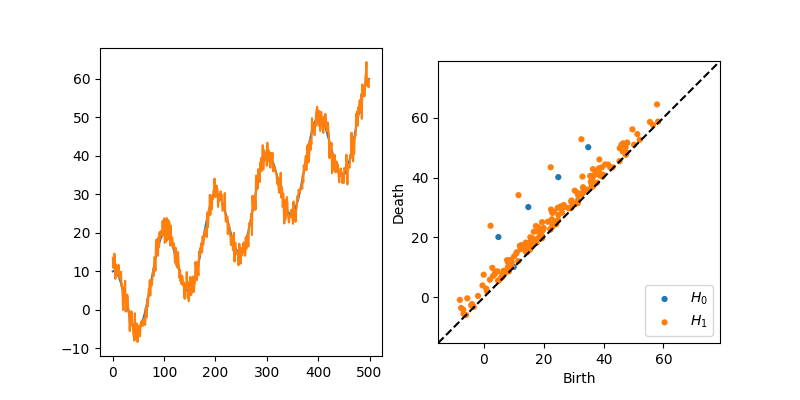

<IPython.core.display.Javascript object>


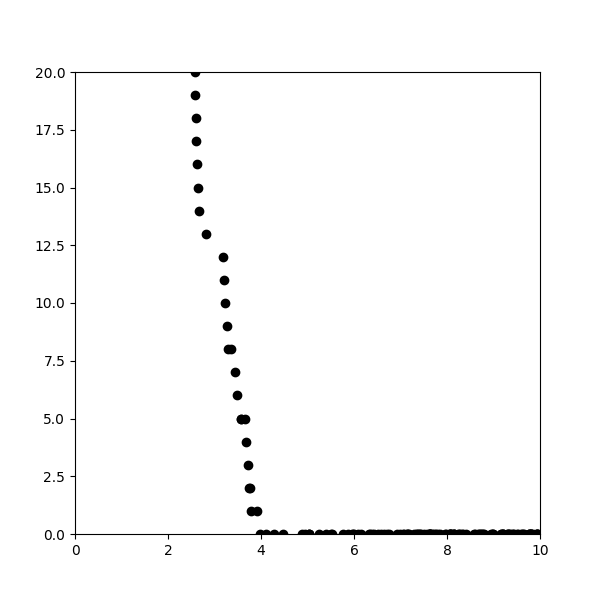

In [43]:

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(x)
plt.plot(y)
#plt.subplot(132)
#plot_diagrams([Ix, Iy], labels = ['H0 Original', 'H0 Noisy'])

#plt.title("Wasserstein = %.3g, Bottleneck = %.3g, Prokhorov = %.3g"%(dw, db,dp))
plt.subplot(122)
#plt.title("Prokhorov distance = %.3g"%dp)
persim.plot_diagrams([Ix,Iy])
#wasserstein_matching(Ix,Iy,matchidxp)
#plt.subplot(133)
#plt.title("Bottleneck distance = %.3g"%db)
#bottleneck_matching(Ix,Iy,matchidxb,bD)

diam = np.max([[max(abs(x[0]-y[0]), abs(x[1]-y[1]))for x in Ix] for y in Iy])
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(unmatched_series[:, 0], unmatched_series[:, 1], c="k")
#add_identity(ax, color='r', ls='--')
#x = np.linspace(0.1, 100, 200) 
#for p in range(1,11):
#    W_p = gudhi.hera.wasserstein_distance(Ix, Iy, order = p, internal_p = float("inf"))
#    h1 = plt.plot(x, (W_p**p)/(x**p), lw=2)
#    h2 = plt.plot(x, (((W_p**p)-x*(len(Ix)+len(Iy)))/(diam**p-x))**p, lw=2)
ax.set_xlim([0,10])
ax.set_ylim([0,20])
plt.show()
#plt.savefig("Prokhorov.png")

In [32]:
np.random.seed(0)
NSamples = 250
t = np.linspace(0, 50, NSamples)
x = 10*(np.cos(0.1*np.pi*t) + 0.1*t)
y = x + 2*np.random.randn(NSamples)

Dx = getLowerStarTimeSeriesD(x)
Dy = getLowerStarTimeSeriesD(y)
Ix = ripser.ripser(Dx, distance_matrix=True, maxdim=0)['dgms'][0]
Iy = ripser.ripser(Dy, distance_matrix=True, maxdim=0)['dgms'][0]

#plt.subplot(132)
#plot_diagrams([Ix, Iy], labels = ['H0 Original', 'H0 Noisy'])

#Remove point at infinity before bottleneck/wasserstein
Ix = Ix[np.isfinite(Ix[:, 1]), :]
Iy = Iy[np.isfinite(Iy[:, 1]), :]

tic = time.time()
dw = wasserstein(Ix, Iy)
print("Elapsed time Wasserstein: %.3g"%(time.time()-tic))
print("Wasserstein distance: {}".format(dw))
tic = time.time()
db, (matchidxb, bD) = bottleneck(Ix, Iy, matching = True)
print("Elapsed time Bottleneck: %.3g"%(time.time()-tic))
print("Bottleneck distance: {}".format(db))
tic = time.time()
dp, matchidxp = prokhorov(Ix, Iy, matching = True)
print("Elapsed time Prokhorov: %.3g"%(time.time()-tic))
print("Prokhorov distance: {}".format(dp))

unmatched_series = prokhorov_series(Ix,Iy)


Elapsed time Wasserstein: 0.00125
Wasserstein distance: 160.14860817993502
Elapsed time Bottleneck: 0.0295
Bottleneck distance: 3.987010419368744
51.893940567970276
Elapsed time Prokhorov: 0.225
Prokhorov distance: 3.5479693601352835


<IPython.core.display.Javascript object>


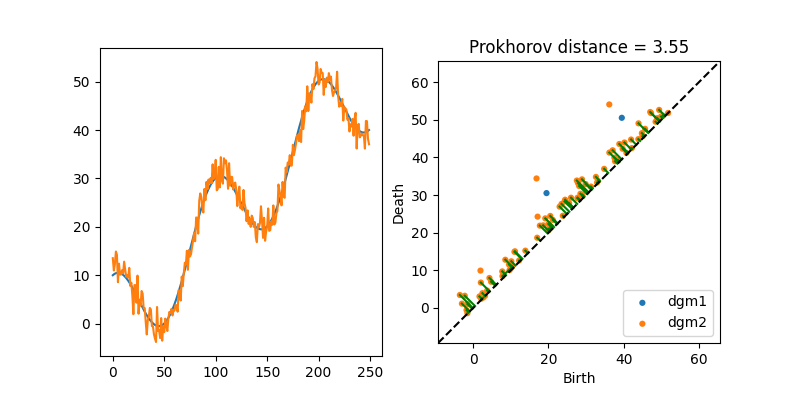

<IPython.core.display.Javascript object>


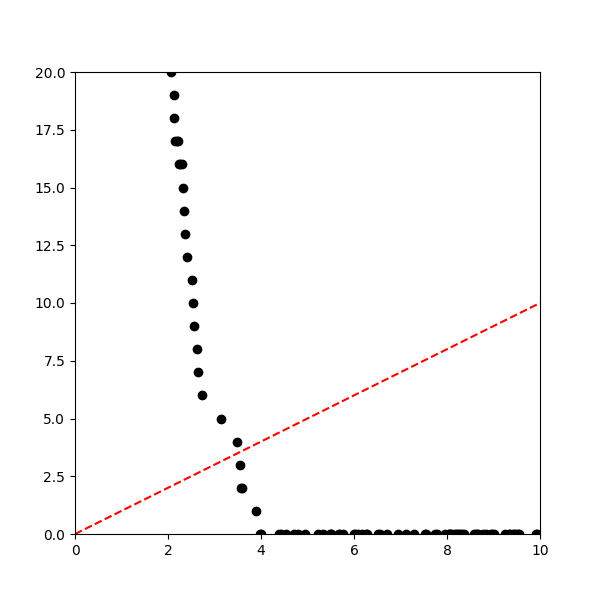

In [34]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(x)
plt.plot(y)
#plt.title("Wasserstein = %.3g, Bottleneck = %.3g, Prokhorov = %.3g"%(dw, db,dp))
plt.subplot(122)
plt.title("Prokhorov distance = %.3g"%dp)
wasserstein_matching(Ix,Iy,matchidxp)
#plt.subplot(133)
#plt.title("Bottleneck distance = %.3g"%db)
#bottleneck_matching(Ix,Iy,matchidxb,bD)

f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(unmatched_series[:, 0], unmatched_series[:, 1], c="k")
add_identity(ax, color='r', ls='--')
x = np.linspace(0, 100, 2000) 
#for p in range(1,5):
#    W_p = gudhi.hera.wasserstein_distance(Ix, Iy, order = p, internal_p = float("inf"))
#    h1 = plt.plot(x, x**p, lw=2)
#    h2 = plt.plot(x, x**(1/p), lw=2)
ax.set_xlim([0,10])
ax.set_ylim([0,20])

plt.show()

56.02063989639282


<IPython.core.display.Javascript object>


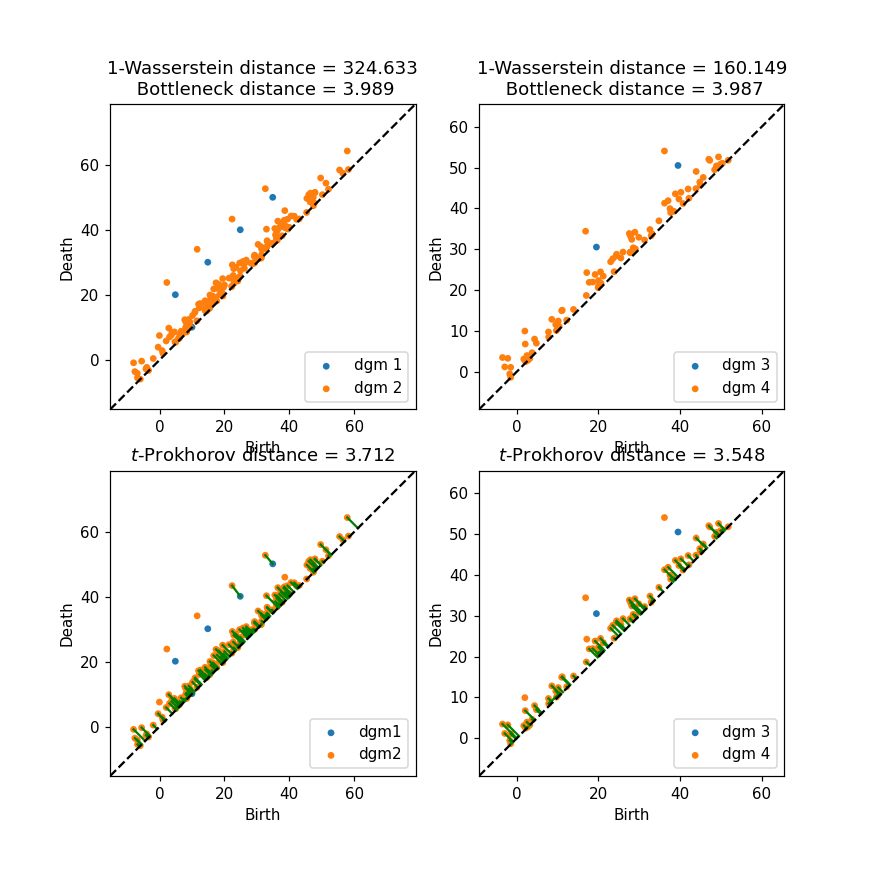

51.893940567970276


In [23]:
np.random.seed(0)
NSamples = 500
t = np.linspace(0, 50, NSamples)
x = 10*(np.cos(0.2*np.pi*t) + 0.1*t)
y = x + 2*np.random.randn(NSamples)

Dx = getLowerStarTimeSeriesD(x)
Dy = getLowerStarTimeSeriesD(y)
Ix = ripser.ripser(Dx, distance_matrix=True, maxdim=0)['dgms'][0]
Iy = ripser.ripser(Dy, distance_matrix=True, maxdim=0)['dgms'][0]

#Remove point at infinity before bottleneck/wasserstein
Ix = Ix[np.isfinite(Ix[:, 1]), :]
Iy = Iy[np.isfinite(Iy[:, 1]), :]

dp, matchidxp = prokhorov(Ix, Iy, matching = True)
dw = wasserstein(Ix, Iy)
db = bottleneck(Ix, Iy)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title("1-Wasserstein distance = {}\n Bottleneck distance = {}".format(round(dw,3),round(db,3)))
persim.plot_diagrams([Ix,Iy], labels=["dgm 1", "dgm 2"])
plt.subplot(223)
plt.title('$t$-Prokhorov distance = {}'.format(round(gudhi.prokhorov_distance(Ix,Iy,np.array([0,1,0])),3)))
wasserstein_matching(Ix,Iy,matchidxp)

np.random.seed(0)
NSamples = 250
t = np.linspace(0, 50, NSamples)
x = 10*(np.cos(0.1*np.pi*t) + 0.1*t)
y = x + 2*np.random.randn(NSamples)

Dx = getLowerStarTimeSeriesD(x)
Dy = getLowerStarTimeSeriesD(y)
Ix = ripser.ripser(Dx, distance_matrix=True, maxdim=0)['dgms'][0]
Iy = ripser.ripser(Dy, distance_matrix=True, maxdim=0)['dgms'][0]

Ix = Ix[np.isfinite(Ix[:, 1]), :]
Iy = Iy[np.isfinite(Iy[:, 1]), :]

dp, matchidxp = prokhorov(Ix, Iy, matching = True)
dw = wasserstein(Ix, Iy)
db = bottleneck(Ix, Iy)

plt.subplot(222)
plt.title("1-Wasserstein distance = {}\n Bottleneck distance = {}".format(round(dw,3),round(db,3)))
persim.plot_diagrams([Ix,Iy], labels=["dgm 3", "dgm 4"])
plt.subplot(224)
plt.title('$t$-Prokhorov distance = {}'.format(round(gudhi.prokhorov_distance(Ix,Iy,np.array([0,1,0])),3)))
wasserstein_matching(Ix,Iy,matchidxp, labels=["dgm 3", "dgm 4"])
plt.show()

In [30]:
tic = time.time()
dp = prokhorov(Ix, Iy)
print("Elapsed Time Matching: %.3g"%(time.time()-tic))
print(dp)
tic = time.time()
dp = fast_prokhorov(Ix, Iy)
print("Elapsed Time Matching: %.3g"%(time.time()-tic))
print(dp)

51.893940567970276
Elapsed Time Matching: 0.377
3.5479693601352835
for t = 17.316044807434082 the matching has size 90
for t = 5.224299907684326 the matching has size 90
for t = 1.2052764892578125 the matching has size 53
for t = 2.3160390853881836 the matching has size 75
for t = 3.565277099609375 the matching has size 88
for t = 2.6200551986694336 the matching has size 82
for t = 3.148405075073242 the matching has size 85
for t = 3.5479736328125 the matching has size 87
for t = 3.4834970235824585 the matching has size 86
Elapsed Time Matching: 0.00902
3.5479736328125


In [51]:
def fast_prokhorov(Ix, Iy):
    X_0 = [(x[0],x[1]) for x in Ix]
    Y_0 = [(y[0],y[1]) for y in Iy]
    X_0prime = {x:((x[1]+x[0])/2,(x[1]+x[0])/2) for x in X_0}
    Y_0prime = {y:((y[1]+y[0])/2,(y[1]+y[0])/2) for y in Y_0}

    dists = {}
    for u in X_0:
        for v in Y_0:
            dists[(u,v)]=max(abs(u[0]-v[0]),abs(u[1]-v[1]))
    for u in X_0:
        dists[(u,X_0prime[u])]=(u[1]-u[0])/2
    for v in Y_0:
        dists[(Y_0prime[v],v)]=(v[1]-v[0])/2

    g = Graph()
    for x in X_0:
        g.add_vertices(str(x))
        g.vs[-1]['type']=False
        g.add_vertices(str(X_0prime[x]))
        g.vs[-1]['type']=True
    for y in Y_0:
        g.add_vertices(str(y))
        g.vs[-1]['type']=True
        g.add_vertices(str(Y_0prime[y]))
        g.vs[-1]['type']=False

    g.add_edges([(str(Y_0prime[y]),str(X_0prime[x])) for x in X_0 for y in Y_0])
    
    search_space = np.sort(np.fromiter(list(dists.values())+list(range(0,len(X_0)+len(Y_0))),dtype=float))
    
    L = 0
    R = len(search_space)-1
    t = None
    while(R-L>0):
        old_t = t
        mid = int(np.floor((R+L)/2))
        r = search_space[mid]
        t = r
        es=[(str(x),str(y)) for x in X_0 for y in Y_0 if dists[(x,y)]<=t]+[(str(x),str(X_0prime[x])) for x in X_0 if dists[(x,X_0prime[x])]<=t]+[(str(Y_0prime[y]),str(y)) for y in Y_0 if dists[(Y_0prime[y],y)]<=t]
        g.add_edges(es)
        
        m = g.maximum_bipartite_matching()
        g.delete_edges(es)
        number_of_unmatched_points = len(Ix)+len(Iy)-len(m)
        print("L = {}, R = {}, mid = {}".format(L,R,mid))
        print("for t = {} the matching has size {}".format(t, len(m)))
        if (R-L > 1):
            if number_of_unmatched_points >= t:
                L = mid
            elif number_of_unmatched_points < t:
                R = mid
        else:
            if number_of_unmatched_points >= t:
                L = L+1
            elif number_of_unmatched_points < t:
                R = R-1
    
    return old_t

In [16]:
def fast_prokhorov_series(Ix, Iy):
    X_0 = [(x[0],x[1]) for x in Ix]
    Y_0 = [(y[0],y[1]) for y in Iy]
    X_0prime = {x:((x[1]+x[0])/2,(x[1]+x[0])/2) for x in X_0}
    Y_0prime = {y:((y[1]+y[0])/2,(y[1]+y[0])/2) for y in Y_0}

    dists = {}
    for u in X_0:
        for v in Y_0:
            dists[(u,v)]=max(abs(u[0]-v[0]),abs(u[1]-v[1]))
    for u in X_0:
        dists[(u,X_0prime[u])]=(u[1]-u[0])/2
    for v in Y_0:
        dists[(Y_0prime[v],v)]=(v[1]-v[0])/2

    g = Graph()
    for x in X_0:
        g.add_vertices(str(x))
        g.vs[-1]['type']=False
        g.add_vertices(str(X_0prime[x]))
        g.vs[-1]['type']=True
    for y in Y_0:
        g.add_vertices(str(y))
        g.vs[-1]['type']=True
        g.add_vertices(str(Y_0prime[y]))
        g.vs[-1]['type']=False

    g.add_edges([(str(Y_0prime[y]),str(X_0prime[x])) for x in X_0 for y in Y_0])
        
    #sorted_weights = np.sort(np.fromiter(dists.values(),dtype=float))
    t_vals = np.linspace(0,1000)#max(dists.values()),10*(len(Ix)+len(Iy)))
    unmatched_series = np.zeros((len(t_vals),2))
    index = 0
   
    for t in t_vals:
        es=[(str(x),str(y)) for x in X_0 for y in Y_0 if dists[(x,y)]<=t]+[(str(x),str(X_0prime[x])) for x in X_0 if dists[(x,X_0prime[x])]<=t]+[(str(Y_0prime[y]),str(y)) for y in Y_0 if dists[(Y_0prime[y],y)]<=t]
        g.add_edges(es)
        
        m = g.maximum_bipartite_matching()
        g.delete_edges(es)
        number_of_unmatched_points = len(Ix)+len(Iy)-len(m)
        
        unmatched_series [index,:]=(t, number_of_unmatched_points)
        index = index +1
    
    return(unmatched_series)

In [73]:
# First, sample points from a circle
np.random.seed(0)
# First point cloud has no noise
N1 = 100
X1 = np.zeros((N1, 2))
t1 = np.linspace(0, 2*np.pi, N1+1)[0:N1]
X1[:, 0] = 1*np.cos(t1)-2
X1[:, 1] = 1*np.sin(t1)
X1 = X1 + 0.2*np.random.randn(N1, 2)

# Second point cloud has a lot of noisy points
N2 = 100
t2 = np.linspace(0, 2*np.pi, N2+1)[0:N2]
X2 = np.zeros((N2, 2))
X2[:, 0] = np.cos(t2)+2
X2[:, 1] = np.sin(t2)
X2 = X2 + 0.2*np.random.randn(N2, 2)

N3 = 100
t3 = np.linspace(0, 2*np.pi, N3+1)[0:N3]
X3 = np.zeros((N3, 2))
X3[:, 0] = np.cos(t3)-2
X3[:, 1] = np.sin(t3)
X3 = X3 + 0.2*np.random.randn(N3, 2)

alpha = cm.Alpha()
filtration = alpha.build(X1)
I1 = alpha.diagrams(filtration)[1]
filtration = alpha.build(X2)
I2 = alpha.diagrams(filtration)[1]
filtration = alpha.build(X3)
I3 = alpha.diagrams(filtration)[1]

# Perform the matchings

unmatched_series12 = fast_prokhorov_series(I1,I2)
unmatched_series23 = fast_prokhorov_series(I2,I3)
unmatched_series13 = fast_prokhorov_series(I1,I3)

Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 0.002)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 0.053)
Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.008)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.000969)
Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 0.000998)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 0.055)
Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.009)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.001)
Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 0.002)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 0.0561)
Constructing boundary matrix...
Finished constructing boundary matrix (Elap

<IPython.core.display.Javascript object>


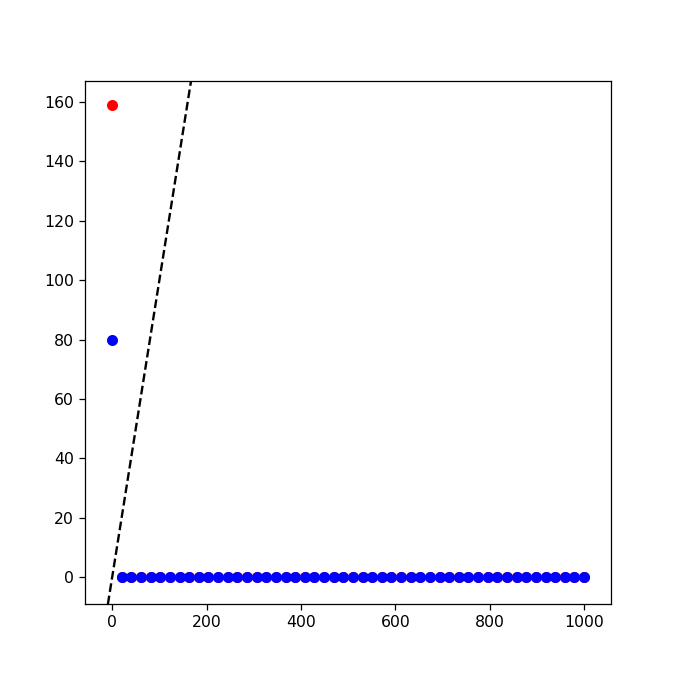

In [74]:
f, ax = plt.subplots(figsize=(6, 6))
#plt.subplot(121)
ax.scatter(unmatched_series12[:, 0], unmatched_series12[:, 1]+unmatched_series23[:, 1], color='r')
#ax.scatter(unmatched_series23[:, 0], unmatched_series23[:, 1], color='g')
ax.scatter(unmatched_series13[:, 0], unmatched_series13[:, 1], color='b')
add_identity(ax, color='k', ls='--')
plt.show()

In [24]:
unmatched_series

array([[   0.        ,   87.        ],
       [  20.40816327,    0.        ],
       [  40.81632653,    0.        ],
       [  61.2244898 ,    0.        ],
       [  81.63265306,    0.        ],
       [ 102.04081633,    0.        ],
       [ 122.44897959,    0.        ],
       [ 142.85714286,    0.        ],
       [ 163.26530612,    0.        ],
       [ 183.67346939,    0.        ],
       [ 204.08163265,    0.        ],
       [ 224.48979592,    0.        ],
       [ 244.89795918,    0.        ],
       [ 265.30612245,    0.        ],
       [ 285.71428571,    0.        ],
       [ 306.12244898,    0.        ],
       [ 326.53061224,    0.        ],
       [ 346.93877551,    0.        ],
       [ 367.34693878,    0.        ],
       [ 387.75510204,    0.        ],
       [ 408.16326531,    0.        ],
       [ 428.57142857,    0.        ],
       [ 448.97959184,    0.        ],
       [ 469.3877551 ,    0.        ],
       [ 489.79591837,    0.        ],
       [ 510.20408163,   

In [92]:
t=4
es=[(str(x),str(y)) for x in X_0 for y in Y_0 if dists[(x,y)]<=t]+[(str(x),str(X_0prime[x])) for x in X_0 if dists[(x,X_0prime[x])]<=t]+[(str(Y_0prime[y]),str(y)) for y in Y_0 if dists[(Y_0prime[y],y)]<=t]
g.add_edges(es)
hk = HopcroftKarp({v.index : set(g.adjacent(v)) for v in g.vs}).maximum_matching()        
m = g.maximum_bipartite_matching()
g.delete_edges(es)

IndexError: list index out of range

In [90]:
len(hk)

194

In [73]:
help(persim.plot_diagrams)

Help on function plot_diagrams in module persim.visuals:

plot_diagrams(diagrams, plot_only=None, title=None, xy_range=None, labels=None, colormap='default', size=20, ax_color=array([0., 0., 0.]), diagonal=True, lifetime=False, legend=True, show=False, ax=None)
    A helper function to plot persistence diagrams. 
    
    Parameters
    ----------
    diagrams: ndarray (n_pairs, 2) or list of diagrams
        A diagram or list of diagrams. If diagram is a list of diagrams, 
        then plot all on the same plot using different colors.
    plot_only: list of numeric
        If specified, an array of only the diagrams that should be plotted.
    title: string, default is None
        If title is defined, add it as title of the plot.
    xy_range: list of numeric [xmin, xmax, ymin, ymax]
        User provided range of axes. This is useful for comparing 
        multiple persistence diagrams.
    labels: string or list of strings
        Legend labels for each diagram. 
        If none ar

In [93]:
{v.index : set(g.adjacent(v)) for v in g.vs}

{0: {255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
  264,
  265,
  266,
  267,
  268,
  269,
  270,
  272},
 1: {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  272},
 2: {271},
 3: {85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  1

In [96]:
g.adjacent(g.vs[173])

[83, 168, 253, 355]

In [41]:
g.vs[0].index

0

In [17]:
def lp_prokhorov(I1, I2):
    X_0 = [(x[0],x[1]) for x in Ix]
    Y_0 = [(y[0],y[1]) for y in Iy]
    X_0prime = [((x[1]+x[0])/2,(x[1]+x[0])/2) for x in X_0]
    Y_0prime = [((y[1]+y[0])/2,(y[1]+y[0])/2) for y in Y_0]
    
    U = X_0+Y_0prime
    V = Y_0+X_0prime
    nodes = U + V
    cap_dict = {}
    for u in X_0:
        for v in Y_0:
            cap_dict[(str(u),str(v))]=1
    for u in X_0:
        for v in X_0prime:
            cap_dict[(str(u),str(v))]=1
    for u in Y_0prime:
        for v in Y_0:
            cap_dict[(str(u),str(v))]=1
    for u in Y_0prime:
        for v in X_0prime:
            cap_dict[(str(u),str(v))]=1
        
    arcs, capacity = gp.multidict(cap_dict)

    
    dists = {}
    for u in X_0:
        for v in Y_0:
            dists[(str(u),str(v))]=max(abs(u[0]-v[0]),abs(u[1]-v[1]))
    for u in X_0:
        for v in X_0prime:
            dists[(str(u),str(v))]=max(abs(u[0]-v[0]),abs(u[1]-v[1]))
    for u in Y_0prime:
        for v in Y_0:
            dists[(str(u),str(v))]=max(abs(u[0]-v[0]),abs(u[1]-v[1]))
    for u in Y_0prime:
        for v in X_0prime:
            dists[(str(u),str(v))]=0

    costs = dict.fromkeys(dists.keys(),0)

    L = 0
    R = max(dists.values())
    
    while(R-L>0.00001):
        t = (R+L)/2
        print(t)
        tic = time.time()

        for key, value in dists.items():
            costs[key]= 1 if value > t else 0
        print("Elapsed Time updating weights: %.3g"%(time.time()-tic))
        # Create optimization model
        m = gp.Model('netflow')

        # Create variables
        flow = m.addVars(arcs, obj=costs, lb = 0, ub = 1, name="flow", vtype = GRB.BINARY)

        m.addConstrs(
        (flow.sum(str(u), '*') == 1
            for u in U), "leftnode")
    
        m.addConstrs(
        (flow.sum('*', str(v)) == 1
            for v in V), "rightnode")
    
        m.reset()
        m.optimize()
        number_of_unmatched_points = m.objVal
        if number_of_unmatched_points > t:
            L = t
        elif number_of_unmatched_points < t:
            R = t
    
    return t